# Support points with Exponential Mechanism

### Procedure:


1. Given data $X = \{x_1, \ldots, x_m\}$ on space $\mathcal{D} \in [0, 1]$, find optimal support points $Y = \{y_1, \ldots, y_n\}$, where $e(X, Y) = \delta$.
2. The energy sensitivity of support points is $S = diam(X) / n$. Therefore sample an energy value $\tilde{e} \sim \mbox{Lap}(2 * S / \epsilon)$.
3. Let $\tilde{Y}$ equal a copy of $Y$. While $e(\tilde{Y}, Y) < \tilde{e}$, perturb all points in $\tilde{Y}$ with small step in a random direction.


_____

In [1]:
%matplotlib inline

import sys
print(sys.version)
import argparse
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import os
import pdb
import sys
import time
import tensorflow as tf
print(tf.__version__)
from scipy.stats import ks_2samp, truncnorm
from scipy.spatial.distance import pdist, squareform

3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
1.13.1


In [2]:
def get_support_points(x, num_support, max_iter=1000, lr=1e-2, is_tf=False):
    # Initialize generated particles for both sets (y and y_).
    d = x.shape[1]
    offset = 0.01

    if Y_INIT_OPTION == 'grid':
        grid_size = int(np.sqrt(num_support))
        assert grid_size == np.sqrt(num_support), 'num_support must square for grid'
        _grid = np.linspace(offset, 1 - offset, grid_size)
        y = np.array(np.meshgrid(_grid, _grid)).T.reshape(-1, d)
        # Perturb grid in order to give more diverse gradients.
        y += np.random.normal(0, 0.005, size=y.shape)
    elif Y_INIT_OPTION == 'random':
        y = np.random.uniform(offset, 1 - offset, size=(num_support, d))
    
    # Optimize particles for each dataset (x0 and x1).
    if is_tf:
        y_out, e_out = optimize_support_points_tf(x, y, max_iter=max_iter, learning_rate=lr)
    else:
        y_out, e_out = optimize_support_points(x, y, max_iter=max_iter, learning_rate=lr)
    
    # Get last updated set as support points.
    sp = y_out[-1]
    
    return sp, e_out

---


In [3]:
def optimize_support_points_tf(data, gen, max_iter=500, learning_rate=1e-2):
    """Runs TensorFlow optimization, n times through proposal points.
    Args:
      data: ND numpy array of any length, e.g. (100, dim).
      gen: ND numpy array of any length, e.g. (10, dim).
      max_iter: Scalar, number of times to loop through updates for all vars.
      learning_rate: Scalar, amount to move point with each gradient update.
      
    Returns:
      y_out: (max_iter,N,D)-array. Trace of generated proposal points.
      e_out: Float, energy between data and last iteration of y_out.
    """
    print('USING TENSORFLOW OPTIMIZATION')
    y_out = np.zeros((max_iter, gen.shape[0], gen.shape[1]))
    
    # Build TensorFlow graph.
    tf.reset_default_graph()
    tf_input_data = tf.placeholder(tf.float32, [None, data.shape[1]], name='input_data')
    tf_candidate_sp = tf.Variable(gen, name='sp', dtype=tf.float32)
    tf_e_out, _ = energy(tf_input_data, tf_candidate_sp, power=ENERGY_POWER, is_tf=True)

    tf_optim = tf.train.AdamOptimizer(learning_rate).minimize(tf_e_out)
    #tf_optim = tf.train.RMSPropOptimizer(learning_rate).minimize(tf_e_out)
    #tf_optim = tf.train.GradientDescentOptimizer(learning_rate).minimize(tf_e_out)
    
    #opt = tf.train.GradientDescentOptimizer(learning_rate)
    #grads, variables = zip(*opt.compute_gradients(tf_e_out))
    #grads_clipped_ = tuple([tf.clip_by_value(g, -0.01, 0.01) for g in grads_])
    #tf_optim = opt.apply_gradients(zip(grads, variables))
    
    # Initialize graph.
    tf_init_op = tf.global_variables_initializer()
    tf_gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
    tf_sess_config = tf.ConfigProto(allow_soft_placement=True, gpu_options=tf_gpu_options)

    # Run training.
    with tf.Session(config=tf_sess_config) as sess:
        sess.run(tf_init_op)

        for it in range(max_iter):
            sess.run([tf_optim], {tf_input_data: data})
            
            data_, sp_, e_, = sess.run(
                [tf_input_data, tf_candidate_sp, tf_e_out],
                {tf_input_data: data})

            # Store result in container.
            y_out[it, :] = sp_
            
            # Plot occasionally.
            if it % SAVE_ITER == 0:
                plt.scatter(data[:,0], data[:,1], c='black', alpha=0.3)
                plt.scatter(sp_[:,0], sp_[:,1], c='red')
                plt.title('it: {}, e_out: {:.8f}'.format(it, e_))
                plt.show()
        
    return y_out, e_

In [4]:
def optimize_support_points(data, gen, max_iter=500, learning_rate=1e-2):
    """Runs alternating optimizations, n times through proposal points.
    Args:
      data: ND numpy array of any length, e.g. (100, dim).
      gen: ND numpy array of any length, e.g. (10, dim).
      max_iter: Scalar, number of times to loop through updates for all vars.
      learning_rate: Scalar, amount to move point with each gradient update.
      
    Returns:
      y_out: (max_iter,N,D)-array. Trace of generated proposal points.
      e_out: Float, energy between data and last iteration of y_out.
    """
    y_out = np.zeros((max_iter, gen.shape[0], gen.shape[1]))
    
    # Run optimization steps.
    for it in range(max_iter):
        e_out, e_grads = energy(data, gen, power=ENERGY_POWER)
        gen -= learning_rate * e_grads
        
        y_out[it, :] = gen
        
        # Plot occasionally.
        if it % 100 == 0:
            plt.scatter(data[:,0], data[:,1], c='black', alpha=0.3)
            plt.scatter(gen[:,0], gen[:,1], c='red')
            plt.title('it: {}, e_out: {:.8f}'.format(it, e_out))
            plt.show()
        
        
    return y_out[:it], e_out

In [5]:
def energy(data, gen, sigma=1., power=1., is_tf=False):
    """Computes abbreviated energy statistic between two point sets.

    The smaller the value, the closer the sets.
    Args:
      data: ND numpy array of any length, e.g. (1000, 2).
      gen: ND numpy array of any length, e.g. (10, 2).
      sigma: Float, kernel lengthscale.
      power: Exponent in distance metric. Must be >= 1.
      is_tf: Boolean. Selects for TensorFlow functions.
    Returns:
      e: Scalar, the energy between the sets.
      mmd: Scalar, the mmd between the sets.
      gradients_e: Numpy array of energy gradients for each proposal point.
    """
    assert power >= 1, 'Power must be >= 1.'
    
    
    # ------------- NumPy VERSION -------------
    
    if not is_tf:
        x = data
        y = gen
        dim = x.shape[1]
        data_num = len(x)
        gen_num = len(y)
        
        # Compute energy.
        v = np.concatenate((x, y), 0)
        v_tiled_across = np.tile(v[:, np.newaxis, :], (1, v.shape[0], 1))
        v_tiled_down = np.tile(v[np.newaxis, :, :], (v.shape[0], 1, 1))
        pairwise_difs = v_tiled_across - v_tiled_down
        energy = np.linalg.norm(pairwise_difs, axis=2, ord=power)

        energy_xx = energy[:data_num, :data_num]
        energy_yy = energy[data_num:, data_num:]
        energy_xy = energy[:data_num, data_num:]
                
        energy_xx_upper = np.triu(energy_xx)
        energy_yy_upper = np.triu(energy_yy)
        
        num_combos_x = data_num * (data_num - 1) / 2
        num_combos_y = gen_num * (gen_num - 1) / 2
        num_combos_xy = data_num * gen_num

        e = (2. / gen_num / data_num * np.sum(energy_xy) -
             1. / data_num / data_num * np.sum(energy_xx) -
             1. / gen_num / gen_num * np.sum(energy_yy))
        #e = (2. / num_combos_xy * np.sum(energy_xy) -
        #     1. / num_combos_x * np.sum(energy_xx_upper) -
        #     1. / num_combos_y * np.sum(energy_yy_upper))
    
    
        # Compute energy gradients.    
        # Note: Term2 assumes y in first position. For y in second position,
        #       need to multiply grad_matrix by -1.
        if power == 1:
            term1 = np.sign(np.sum(pairwise_difs, axis=2))
            term2 = np.sign(pairwise_difs)
        else:
            c1 = 1. / power
            
            # Define term containing Infs on diag, then replace Infs w/ zero.
            term1 = c1 * np.sum(pairwise_difs ** power, axis=2) ** (c1 - 1)
            np.fill_diagonal(term1, 0)
            
            term2 = power * (pairwise_difs ** (power - 1))
            
        assert len(term1[:,:,np.newaxis].shape) == len(term2.shape)
        grad_matrix = term1[:, :, np.newaxis] * term2
        grad_matrix_yx = grad_matrix[data_num:, :data_num]
        grad_matrix_yy = grad_matrix[data_num:, data_num:]

        gradients_e = np.zeros((gen_num, dim))
        for i in range(gen_num):
            grad_yi = (2. / data_num / gen_num * np.sum(grad_matrix_yx[i], axis=0) -
                       2. / gen_num / gen_num * np.sum(grad_matrix_yy[i], axis=0))
            gradients_e[i] = grad_yi
        
    
    # ------------- TensorFlow VERSION -------------
    
    elif is_tf:
        x = data
        y = gen
        dim = tf.shape(x)[1]
        data_num = tf.shape(x)[0]
        gen_num = tf.shape(y)[0]

        # Compute energy.
        v = tf.concat([x, y], 0)
        v_tiled_across = tf.tile(tf.expand_dims(v, 1), [1, tf.shape(v)[0], 1])
        v_tiled_down = tf.tile(tf.expand_dims(v, 0), [tf.shape(v)[0], 1, 1])
        pairwise_difs = v_tiled_across - v_tiled_down
        
        # Replace diagonals (which are Infs) with zeros.
        diag_filler = 1e-10 * tf.eye(tf.shape(pairwise_difs)[0])
        diag_filler = tf.tile(
            tf.expand_dims(diag_filler, 2),
            [1, 1, tf.shape(pairwise_difs)[2]])
        pairwise_difs = pairwise_difs + diag_filler
        
        # Define energy over pairwise difs.
        energy = tf.norm(pairwise_difs, axis=2, ord=power)
        
        energy_xx = energy[:data_num, :data_num]
        energy_yy = energy[data_num:, data_num:]
        energy_xy = energy[:data_num, data_num:]

        energy_xx_upper = tf.matrix_band_part(energy_xx, 0, -1)
        energy_yy_upper = tf.matrix_band_part(energy_yy, 0, -1)
        
        #m = tf.cast(data_num, tf.float32)
        #n = tf.cast(gen_num, tf.float32)
        num_combos_x = tf.cast(data_num * (data_num - 1) / 2, tf.float32)
        num_combos_y = tf.cast(gen_num * (gen_num - 1) / 2, tf.float32)
        num_combos_xy = tf.cast(data_num * gen_num, tf.float32)
        
        #e = (2. / n / m * tf.reduce_sum(energy_xy) -
        #     1. / m / m * tf.reduce_sum(energy_xx) -
        #     1. / n / n * tf.reduce_sum(energy_yy))
        e = (2. / num_combos_xy * tf.reduce_sum(energy_xy) -
             1. / num_combos_x * tf.reduce_sum(energy_xx_upper) -
             1. / num_combos_y * tf.reduce_sum(energy_yy_upper))
        
        gradients_e = None

    return e, gradients_e


In [6]:
def plot_single_run(y_out, e_out, p, num_support):
    data_markers_x = [y_out.shape[0]] * len(p)
    data_markers_y = p
    plt.scatter(data_markers_x, data_markers_y, marker='x', label='data')
    plt.plot(y_out, 'k-', alpha=0.3)
    plt.legend(loc='upper left')
    plt.title('|data|=m={}, |support|=n={}, e(x,y)={:.4f}'.format(
              len(p), num_support, e_out))
    plt.savefig('support_points_path.png');
    plt.show()

In [7]:
def sample_sp_exp_mech(e_out, energy_sensitivity, y, max_iter, lr, eps=1.):        
    # Sample energy distance. Must be larger than optimal energy distance.
    # Then sample support points at that energy distance.
    #e_tilde = 0.
    #while e_tilde < e_out:
    #    e_tilde = np.random.laplace(scale=2. * energy_sensitivity / eps)
    e_tilde = np.random.laplace(scale=2. * energy_sensitivity / eps)
    
    # Sample support points:
    
    # ---------- ALGORITHM 1: DIFFUSE FROM OPTIMAL ----------
    
    # Start with copy of optimal support points, then diffuse until 
    # energy(true, copy) is at least e_tilde.
    y_tilde = y.copy()
    energy_y_y_tilde = 0.
    count = 0
    max_count = 5e5
    while energy_y_y_tilde < e_tilde and count < max_count:
        y_tilde += np.random.normal(0, DIFFUSION_SIZE, size=y_tilde.shape)
        energy_y_y_tilde, _ = energy(y, y_tilde)
        #if count % 500 == 0:
        #    print('e_tilde: {:.3f}, energy_y_y_tilde: {:.3f}'.format(e_tilde, energy_y_y_tilde))
        count += 1
    if count < max_count:
        print('Diffusion count {:5}, e~: {:.3f}, energy(y,y~): {:.3f}, error%: {:.3f}'.format(
            count, e_tilde, energy_y_y_tilde, (energy_y_y_tilde - e_tilde) / e_tilde))
    else:
        y_tilde = np.zeros(len(y))
        #print('DID NOT REACH E-TILDE LEVEL')
        #sys.exit()
        
    # -------------------------------------------------------
        
    return y_tilde

____

In [8]:
# Set global constants.
# main()
IS_TF = True              # Boolean. Use TensorFlow rather than analytical gradients.
ENERGY_POWER = 2          # [1., 2.]
Y_INIT_OPTION = 'grid'    # ['random', 'grid']
DATA_SOURCE = 'balog'     # ['balog', 'gaussian', 'gamma', 'laplace', 'beta']
MAX_ITER = 5000           # Num iterations in each support point optimization.
SAVE_ITER = 500           # How often to plot results during training.
LR = 1e-1                 # Energy optimization learning rate.
DIFFUSION_SIZE = 1e-1     # Scale of noise diffusion in ExpMech step.
EPS = 1                  # Differential privacy level.
N = 100                   # Number of support points.

In [9]:
if DATA_SOURCE == 'balog':
    os.system('python data.py 500 2')
    DATA_PATH = '../data/mixture_of_Gaussians_N500_D2.npz'

[OK] Loaded m=500 private data points with dimension d=2


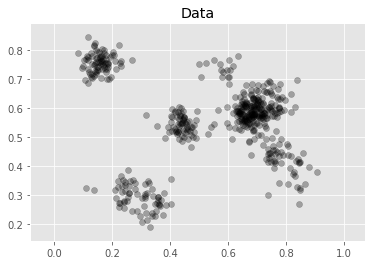

In [10]:
# Load data.
if DATA_SOURCE == 'balog':
    data = np.load(DATA_PATH)
    x = data['X_private']
    m, d = np.shape(x)
    print('[OK] Loaded m=%d private data points with dimension d=%d' % (m, d))
    plt.scatter(x[:,0], x[:,1], c="black", alpha=0.3);
    plt.title('Data');
    plt.axis('equal')
    plt.show()
elif DATA_SOURCE == 'gaussian':
    a, b = -3, 3
    x = truncnorm.rvs(a, b, size=m)
    x = np.sort(x)
    diam_x = b - a
elif DATA_SOURCE == 'beta':
    a, b = 2, 2
    x = np.random.beta(a, b, size=m)
    x = np.sort(x)
    diam_x = 1.
else:
    print('Set up fn for unknown data_source')
    sys.exit()

USING TENSORFLOW OPTIMIZATION
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


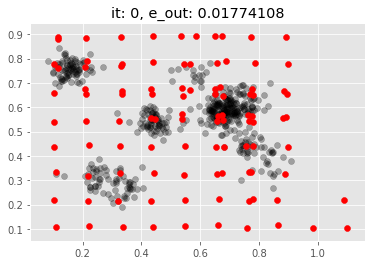

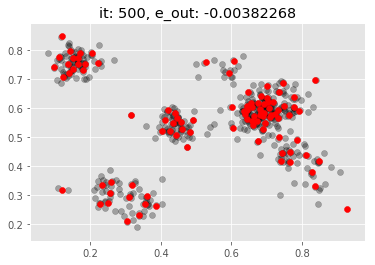

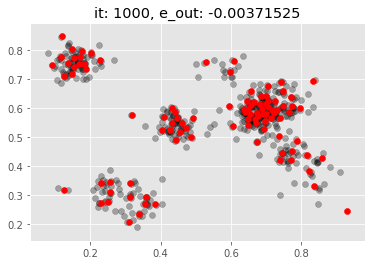

KeyboardInterrupt: 

In [11]:
# Compute m support points on full set.
y, e_out = get_support_points(x, N, MAX_ITER, LR, is_tf=IS_TF)

In [ ]:
# Define energy sensitivity for Exponential Mechanism.
energy_sensitivity = np.sqrt(d) / N
print('Laplace(2 * S / eps) = Laplace(2 * {:.4f} / {:.2f}) = Laplace({:.3f})'.format(
    energy_sensitivity, EPS, 2. * energy_sensitivity / EPS))

In [ ]:
# Sample support points.
y_tildes = []
num_y_tildes = 10

for i in range(num_y_tildes):
    y_tildes.append(sample_sp_exp_mech(e_out, energy_sensitivity, y, MAX_ITER, LR, eps=EPS))

In [ ]:
# Plot results.
for y_t in y_tildes:
    plt.scatter(x[:,0], x[:,1], c='black', label='data',
                alpha=0.3)
    plt.scatter(y[:,0], y[:,1], c='green', label='sp(data)', s=64)
    plt.scatter(y_t[:,0], y_t[:,1], c='red', label='sp(data) + noise', s=16)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('SP samples, EPS={}'.format(EPS))
    plt.show()